In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [11]:
cancer_QA = '../Data_csvs/CancerQA.csv'
diabetes_digestive = '../Data_csvs/Diabetes_and_Digestive_and_Kidney_DiseasesQA.csv'
disease_control = '../Data_csvs/Disease_Control_and_PreventionQA.csv'
generic_rare_disease = '../Data_csvs/Genetic_and_Rare_DiseasesQA.csv'
hormones = '../Data_csvs/growth_hormone_receptorQA.csv'
heart_lung = '../Data_csvs/Heart_Lung_and_BloodQA.csv'
medicalQA = '../Data_csvs/MedicalQuestionAnswering.csv'
neurological_disorders = '../Data_csvs/Neurological_Disorders_and_StrokeQA.csv'
otherQA = '../Data_csvs/OtherQA.csv'
seniorQA = '../Data_csvs/SeniorHealthQA.csv'



In [16]:
files = [
    cancer_QA, diabetes_digestive, disease_control, generic_rare_disease,
    hormones, heart_lung, medicalQA, neurological_disorders, otherQA, seniorQA
]

dfs = [pd.read_csv(file) for file in files]

# Merge
data_df = pd.concat(dfs, ignore_index=True)
data_df.drop(columns='split',axis=1, inplace=True)

print(data_df.shape)
data_df.head()


(32812, 3)


,Question,Answer,topic
0,What is (are) Non-Small Cell Lung Cancer ?,Key Points\n - Non-small ce...,cancer
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer
2,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer
3,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer
4,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer


In [17]:
data_df.columns

Index(['Question', 'Answer', 'topic'], dtype='object')

## Simple EDA

/var/folders/95/00r3y4ys0cxgk7xbsyl1smv00000gn/T/ipykernel_13490/2694319319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, x='topic', order=data_df['topic'].value_counts().index, palette="viridis")


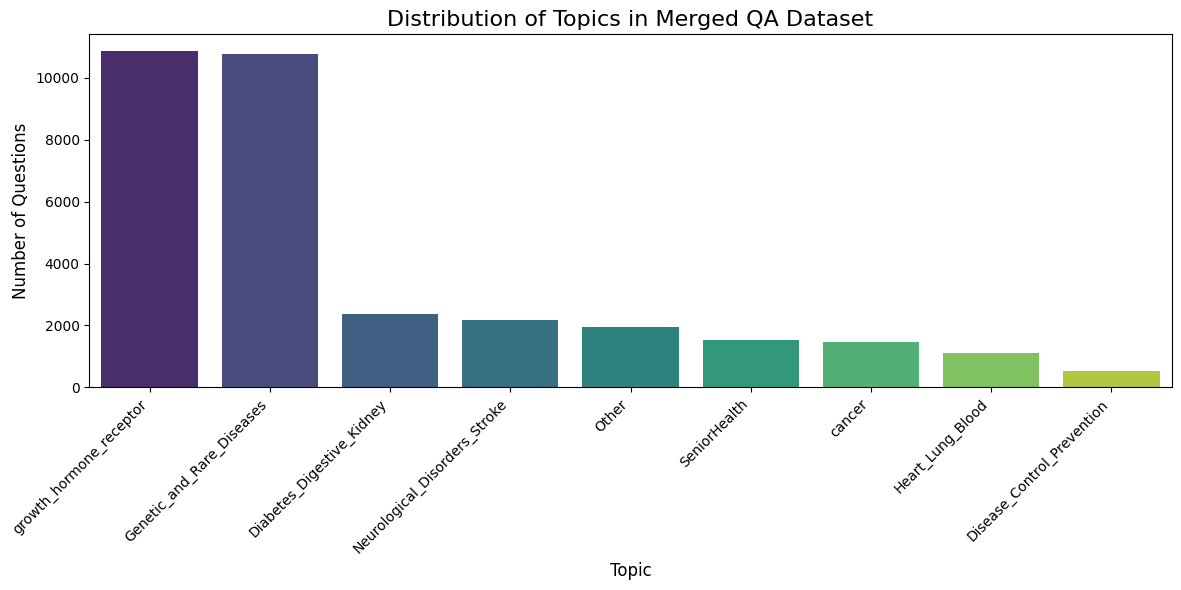

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(data=data_df, x='topic', order=data_df['topic'].value_counts().index, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Topics in Merged QA Dataset', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.tight_layout()
plt.savefig('Topicdistirbution.png', dpi=300)
plt.show()

In [25]:
for topic in data_df['topic'].unique():
    print(f"{topic.upper()} EXAMPLES")
    print("=" * 60)

    topic_data = data_df[data_df['topic'] == topic].head(5)

    for idx, row in topic_data.iterrows():
        print(f"Q: {row['Question']}")
        print(f"A: {row['Answer'][:200]}...")  # First 200 characters
        print("-" * 40)


CANCER EXAMPLES
Q: What is (are) Non-Small Cell Lung Cancer ?
A: Key Points
                    - Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung.     - There are several types of non-small cell lung cancer....
----------------------------------------
Q: Who is at risk for Non-Small Cell Lung Cancer? ?
A: Smoking is the major risk factor for non-small cell lung cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get ...
----------------------------------------
Q: What are the symptoms of Non-Small Cell Lung Cancer ?
A: Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Sometimes lung cancer does not cause any signs or symptoms. It may be found during a chest x-ray done ...
----------------------------------------
Q: How to diagnose Non-Small Cell Lung Cancer ?
A: Tests that examine the lungs are u

In [28]:
## adding index for future retrieval
data_df = data_df.reset_index(drop=True)
data_df['id'] = data_df.index +1
order = ['id', 'Question', 'Answer', 'topic']

data_df = data_df[order]
data_df


,id,Question,Answer,topic
0,1,What is (are) Non-Small Cell Lung Cancer ?,Key Points\n - Non-small ce...,cancer
1,2,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer
2,3,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer
3,4,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer
4,5,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer
...,...,...,...,...
32807,32808,What is (are) Dry Mouth ?,Sjgren's Syndrome Clinic National Institute o...,SeniorHealth
32808,32809,What is (are) Dry Mouth ?,For information about the clinical trial on th...,SeniorHealth
32809,32810,What are the treatments for Dry Mouth ?,Dry mouth treatment will depend on what is cau...,SeniorHealth
32810,32811,What is (are) Dry Mouth ?,You should avoid sticky and sugary foods. If y...,SeniorHealth


## Cleaning

In [82]:
example = data_df['Answer'][711]
example

"Certain factors affect treatment options and prognosis (chance of recovery). Treatment options depend on: - The stage of the disease. - Red blood cell, white blood cell, and platelet blood counts. - Whether there are signs or symptoms, such as fever, chills, or weight loss. - Whether the liver, spleen, or lymph nodes are larger than normal. - The response to initial treatment. - Whether the CLL has recurred (come back). The prognosis (chance of recovery) depends on: - Whether there is a change in the DNA and the type of change, if there is one. - Whether lymphocytes are spread throughout the bone marrow. - The stage of the disease. - Whether the CLL gets better with treatment or has recurred (come back). - Whether the CLL progresses to lymphoma or prolymphocytic leukemia. - The patient's general health."

In [84]:
def clean_answer(text):
    result = text.replace('- ', ' ')
    # Remove citation numbers at the end of sentences
    result = re.sub(r'\d+(?=\s|$|[.,;:])', '', result)
    result = ' '.join(result.split())

    return result


clean_answer(example)


"Certain factors affect treatment options and prognosis (chance of recovery). Treatment options depend on: The stage of the disease. Red blood cell, white blood cell, and platelet blood counts. Whether there are signs or symptoms, such as fever, chills, or weight loss. Whether the liver, spleen, or lymph nodes are larger than normal. The response to initial treatment. Whether the CLL has recurred (come back). The prognosis (chance of recovery) depends on: Whether there is a change in the DNA and the type of change, if there is one. Whether lymphocytes are spread throughout the bone marrow. The stage of the disease. Whether the CLL gets better with treatment or has recurred (come back). Whether the CLL progresses to lymphoma or prolymphocytic leukemia. The patient's general health."

In [85]:
data_df['Answer'] = data_df['Answer'].apply(clean_answer)
data_df['Answer'][0]

'Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs in the chest. The lungs bring oxygen into the body as you breathe in. They release carbon dioxide, a waste product of the bodys cells, as you breathe out. Each lung has sections called lobes. The left lung has two lobes. The right lung is slightly larger and has three lobes. Two tubes called bronchi lead from the trachea (windpipe) to the right and left lungs. The bronchi are sometimes also involved in lung cancer. Tiny air sacs called alveoli and small tubes called bronchioles make up the inside of the lungs. A thin membrane called the pleura covers the outside of each lung and lines the inside wall of the chest cavity. This creates a sac called the pleural cavity. The pleural cavity normally contains a small amount of fluid that helps the lungs move smoothly in the chest when you breathe. There are two main types of lung canc

## Chunking larger text --> this will also mean we need to
# i can use this chunk to generate the fround truth dataset, from each chunk we can genrated 5 different questions, evaluation retrieval, document hit rate and chunck hit rate

In [112]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50    #  context continuity
)

def chunk_texts(df):
    rows = []
    for _, row in df.iterrows():
        answer = row['Answer']
        chunks = splitter.split_text(answer)
        for i, chunk in enumerate(chunks):
            rows.append({
                "doc_id": row['id'],                      # keep original id
                "chunk_index": i,                     # chunk order
                "topic": row['topic'],                # keep metadata
                "question": row['Question'],          # original question
                "original_answers": row["Answer"],
                "chunk_text": chunk                   # the actual chunk
            })
    return pd.DataFrame(rows)

df = chunk_texts(data_df)

In [113]:
df.to_csv('../Data_csvs/data.csv', index=False)

## check for duplicates